# Homework #3 - PyMC Usage

### Q0. The dataset that I choose to use is 'Obesity prediction' on Kaggle. The website url is 'https://www.kaggle.com/datasets/mrsimple07/obesity-prediction/data'.

In [10]:
# Load the Data
import pandas as pd
data = pd.read_csv('/content/obesity_data.csv')

In [15]:
import pymc as pm
import numpy as np
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt

### Q1. I have chosen the variable "Weight" as the weights of the samples tend to follow a normal distribution.

In [13]:
x = data[["Weight"]]

normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=0, sigma=1)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=x)

with normal_gamma_toy_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

with normal_gamma_toy_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'theta': 0.9998, 'phi': 1.0038} | MH Split-Rhats {'theta': 1.6596, 'phi': 1.1231}


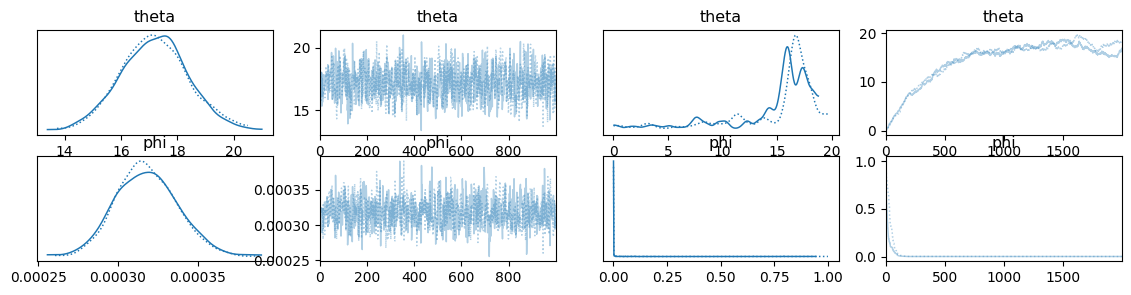

In [16]:
fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2])
az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ')
print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})

### It can be seen that by HMC, the MCMC simulation has gone well. The density plots of both parameters $\theta$ and $\phi$ seems to be symmetric, bell-shaped curve, resembling to normal distributions. Meanwhile, for the trace plots, the values oscillates around a certain value, meaning that the chain has converged.  

Autocorrelation for HMC (MCMC) chain 0.42337780236236344


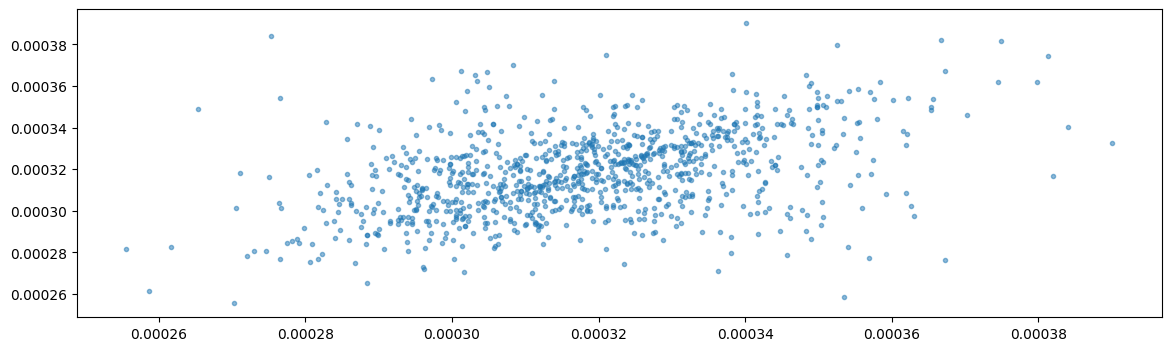

In [18]:
fig,ax = plt.subplots(1,1, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_one_step_ahead = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

### Moving on with the autocorrelation plot for HMC MCMC chain. The plot shows some kind of (very weak) positive correlation, but generally the dots scattered around the graph, which is acceptable. The summary is in the following section (it seems that the $\phi$ parameter is not estimated properly):

In [20]:
print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,17.19,1.18,14.89,19.35,0.04,0.03,809.33,1007.89,1.0
phi,0.00,0.00,0.00,0.00,0.00,0.00,779.45,955.33,1.0


### Q2. I have chosen the 'Age' variable where the ***normal-gamma specification*** isn't justified.

### Q3. I have chosen the negative-binomial specification. Since age is a discrete variable, intuitively I thought of binomial distribution. Thus, I choose the negative-binomial conjugate prior.

In [23]:
y = data["Age"]
age_model = pm.Model()
with age_model:
    alpha = pm.Exponential("alpha", 1.0)
    mu = pm.Gamma("mu", alpha=2.0, beta=2.0)
    age = pm.NegativeBinomial("age", mu=mu, alpha=alpha, observed=y)

### Q4. Here is the posterior inference and analysis of the MC.

In [38]:
with age_model:
    idata_HMC_age = pm.sample() # default is the NUTS implementation of HMC

with age_model:
    MH = pm.Metropolis([alpha, mu], S=np.array([1]), tune=False, tune_interval=0)
    idata_MH_age = pm.sample(step=MH) # force MH

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


HMC Split-Rhats {'theta': 0.9998, 'phi': 1.0038} | MH Split-Rhats {'theta': 1.6596, 'phi': 1.1231}


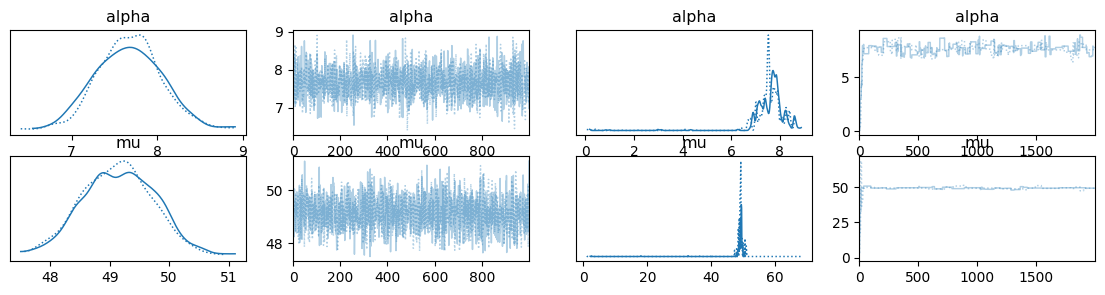

In [39]:
fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC_age, axes=ax[:2,:2])
az.plot_trace(idata_MH_age, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ')
print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})

### Excluding the metropolis algorithm (MH), the left four plots shows that the HMC works properly with a negative-binomial specification. Both density plots shows a symmetric, bell-shaped curve, with a unimodal $\alpha$ and a bimodal $\mu$ parameter. Meanwhile, both trace plots also indicates that the markov chain has converged, as the values oscillates around a certain value.

Autocorrelation for HMC (MCMC) chain -0.03455208720752508
Autocorrelation for HMC (MCMC) chain -0.0585518477979613


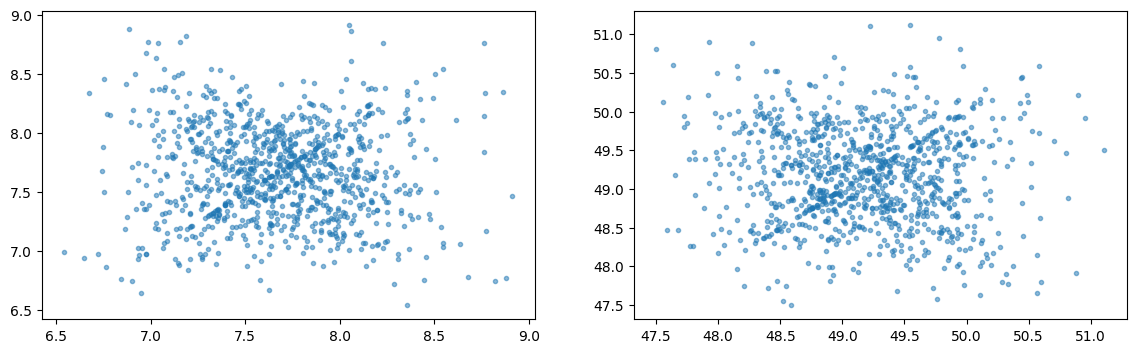

In [51]:
fig,ax = plt.subplots(1,2, figsize=(14,4))

max_mcmc_samples = 1000
mcmc_chain = idata_HMC_age.posterior["alpha"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_one_step_ahead = idata_HMC_age.posterior["alpha"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

mcmc_chain = idata_HMC_age.posterior["mu"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_one_step_ahead = idata_HMC_age.posterior["mu"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

### Autocorrelation plots for both parameters shows almost no correlation. Although showing some signs of negative correlation is generally good for markov chains, in this case it is acceptable that both plots shows a minor negative correlation. The summary of both parameters are shown below. As seen from the previous figures, the r_hat of both $\alpha$ and $\mu$ are very close to 1 (approximated to 1.0 in this case), indicating that the markov chains have converged well.

In [52]:
print("number of MCMC samples:", idata_HMC_age.posterior['alpha'].values.flatten().shape[-1])
az.summary(idata_HMC_age, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,7.67,0.39,6.93,8.38,0.01,0.01,1951.90,1266.26,1.0
mu,49.15,0.60,47.96,50.22,0.01,0.01,2019.79,1661.11,1.0


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

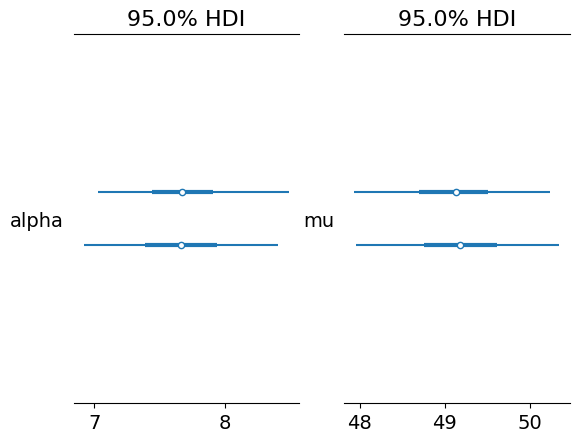

In [62]:
fig,ax = plt.subplots(1,2)
az.plot_forest(idata_HMC_age, var_names=["alpha"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata_HMC_age, var_names=["mu"], combined=False, hdi_prob=0.95, ax=ax[1])

### The 95% bayesian credible interval shows the shortest intervals that there is a 95% probability that both the parameters $\alpha$ and $\mu$ are in. To summarize, it is very likely for the parameter $\alpha$ to be in the range from 7 to 9, while the same for the parameter $\mu$ to be in the range from 48 to 50.